In [1]:
import cv2
import glob
import natsort
import pickle
import imutils
import numpy as np

from utils.hdf5datasetwriter import HDF5DatasetWriter
from utils.aspect_aware_resize import AspectAwareResize

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_paths = natsort.natsorted(glob.glob("train/*.png"))
metadata = pickle.load(open("pkl/metadata.pkl", "rb"))

aar = AspectAwareResize(96, 96)

In [3]:
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
def make_square(image):
    (h, w) = image.shape[:2]
    
    dH = 0
    dW = 0
    
    if h < w:
        dW = (w-h)//2
    elif w < h:
        dH = (h-w) // 2
        
    image = image[dH:h-dH, dW:w-dW]
        
    return image, dH, dW

In [5]:
def xywh_bbox(img, metadata):
    shape = img.shape[:2]
    
    x = int(min(metadata["left"]))
    y = int(min(metadata["top"]))
    w = int(metadata["left"][-1] + metadata["width"][-1])
    h = int(max(metadata["top"]) + max(metadata["height"]))
    
    return x, y, w-x, h-y

In [6]:
def aar_xywh(img, metadata, size=96):
    height, width = img.shape[:2]
    a = height if height < width else width

    img, dH, dW = make_square(img)

    x, y, w, h = xywh_bbox(img, metadata)

    x = x-dW
    y = y-dH

    x = int(x * (size/a))
    y = int(y * (size/a))
    w = int(w * (size/a))
    h = int(h * (size/a))
    return (x, y, w, h)

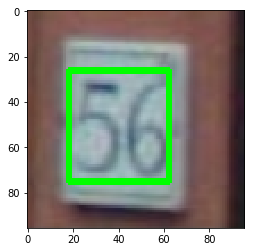

In [7]:
i = 6000

img1_meta = metadata[i]
img1 = cv2.imread(image_paths[i])

x, y, w, h = aar_xywh(img1, img1_meta)

img1 = aar.preprocess(img1)
cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), 2)

imshow(img1)

In [8]:
train_path = natsort.natsorted(glob.glob("train/*.png"))[:-2500]
train_meta = pickle.load(open("pkl/metadata.pkl", "rb"))[:-2500]
val_path = natsort.natsorted(glob.glob("train/*.png"))[-2500:]
val_meta = pickle.load(open("pkl/metadata.pkl", "rb"))[-2500:]
extra_path = natsort.natsorted(glob.glob("extra/*.png"))
extra_meta = pickle.load(open("pkl/metadata_extra.pkl", "rb"))
test_path = natsort.natsorted(glob.glob("test/*.png"))
test_meta = pickle.load(open("pkl/metadata_test.pkl", "rb"))

stuffs = [(train_path, train_meta, "bbox/train.hdf5"), (val_path, val_meta, "bbox/val.hdf5"), 
          (extra_path, extra_meta, "bbox/extra.hdf5"), (test_path, test_meta, "bbox/test.hdf5")]

for (paths, metas, outputs) in stuffs:
    writer = HDF5DatasetWriter((len(paths), 96, 96, 3), outputs)
    for path, meta in zip(paths, metas):
        img = cv2.imread(path)
        label = aar_xywh(img, meta)
        img = aar.preprocess(img)
        writer.add([img], [label])
    writer.close()